In [1]:
# %matplotlib widget

# import ipympl
import re    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from ipywidgets import interactive, HBox, VBox

def imp_data(file):
    specstring_start = 'IR SPECTRUM'          #check orca.out from here
    specstring_end = 'The first'              #stop reading orca.out from here
    # 3 empty lists (first one is not really necessary)
    modelist = []
    freqlist = []
    intenslist = []
    intens_column=3
    try:
        with open(file, "r") as input_file:
            for line in input_file:
                if line.startswith(specstring_start):
                    for line in input_file:
                        if line.startswith(specstring_end):
                            break
                        if re.search("\d:",line): 
                            modelist.append(int(line.strip().split(":")[0])) 
                            freqlist.append(float(line.strip().split()[1]))
                            intenslist.append(float(line.strip().split()[intens_column]))
    except FileNotFoundError:
        print(f"'{file}'" + " not found")
    if modelist:
        return modelist, freqlist, intenslist
    else:
        print(f"'{specstring_start}'" + " not found in" + f"'{file}'")
    
def roundup(x):
    #round to next 100
    return x if x % 100 == 0 else x + 100 - x % 100

def gauss(a,m,x,w):
    # calculation of the Gaussian line shape
    # a = amplitude (max y, intensity)
    # x = position
    # m = maximum/meadian (stick position in x, wave number)
    # w = line width, FWHM
    return a*np.exp(-(np.log(2)*((m-x)/w)**2))

# plot the IR spectrum
def plot_ir(w = 10,                   
            transm_style = True, 
            high_to_low_wn = True, 
            show_stick = True, 
            label_peaks = True,
            show_grid = False,
            show_single_gauss = False):
    # w = line width
    # high_to_low_wn = go from high to low wn 
    # show_stick = show the stick spectrum
    # labe_peaks = label the peaks
    # show_grid = show a grid
    # show_single_gauss = show the single gauss functions

    # always close before draw a new one
    plt.close()

    # list for sum of single gauss functions
    gauss_sum = []
    # position
    freqlist = ir_data[1]
    # intensity
    intenslist = ir_data[2]
    # add some extra space in x 
    wn_add = 120 + w * 2
    # prepare plot
    fig, ax = plt.subplots()
    # plot range in x
    plt_range_x=np.arange(0, max(freqlist) + wn_add, 1)

    # plot single gauss function for every frequency freq if TRUE
    # generate summation of single gauss functions
    for index, freq in enumerate(freqlist):
        if show_single_gauss:
            ax.plot(plt_range_x,gauss(intenslist[index], plt_range_x, freq, w), alpha=0.5) 
            ax.fill_between(plt_range_x,gauss(intenslist[index], plt_range_x, freq, w), alpha=0.5)
        gauss_sum.append(gauss(intenslist[index], plt_range_x, freq, w))
    
    # y values of the gauss summation
    plt_range_gauss_sum_y = np.sum(gauss_sum, axis=0)
    
    # find peaks scipy function, change height for level of detection
    peaks , _ = find_peaks(plt_range_gauss_sum_y, height = 0.1)

    # plot the spectrum
    ax.plot(plt_range_x, plt_range_gauss_sum_y, color="black", linewidth=0.8)

    if save_name != None:
        df = pd.DataFrame({'X': plt_range_x, 'Y': plt_range_gauss_sum_y})
        
        df.to_csv(save_name + '.csv', index=False)


    # show stick spectrum if TRUE
    if show_stick:
        ax.stem(freqlist, intenslist, linefmt="dimgrey", markerfmt=" ", basefmt=" ")

    # title, label, ticks, linear locator
    ax.set_title('IR spectrum', fontweight = 'bold')
    ax.set_xlabel(r'cm$^{-1}$')  
    ax.get_yaxis().set_ticks([])   
    ax.minorticks_on()
    ax.xaxis.set_major_locator(plt.LinearLocator())

    # transmission or absorption style
    if transm_style:
        plt.ylim(max(plt_range_gauss_sum_y)+max(plt_range_gauss_sum_y)*0.1,0)
        ax.set_ylabel('transmittance')
    else:
        plt.ylim(0,max(plt_range_gauss_sum_y)+max(plt_range_gauss_sum_y)*0.1)
        ax.set_ylabel('intensity')
        label_rel_pos_y=5

    # high to low wn or low to high wn
    if high_to_low_wn:
        plt.xlim(roundup(max(plt_range_x)),0) # round to next 100
    else:
        plt.xlim(0,roundup(max(plt_range_x)))

    # show grid if TRUE
    if show_grid:
        ax.grid(True,which='major', axis='x',color='black',linestyle='dotted', linewidth=0.5)

    # show labels on peaks if TRUE
    if label_peaks:
        for index, txt in enumerate(peaks):
            
            if transm_style:
                #corr_factor - maintain distance from label to peak in transmittance style
                #sensitive to peak label font size
                corr_factor = (4 - len(str(peaks[index])))*3.75
                label_rel_pos_y = -15
                #if one does not care:
                corr_factor = 0 
            else:
                # not necessary for absorption style
                label_rel_pos_y=5  
                corr_factor = 0
                
            ax.annotate(peaks[index], xy=(peaks[index], plt_range_gauss_sum_y[peaks[index]]),
                        ha = "center", rotation = 90, size = 6,
                        xytext=(0,label_rel_pos_y+corr_factor), textcoords = 'offset points')

    # resize the Matplotlib window
    N = 1.5
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))

    # tight layout and show
    plt.tight_layout() 
    plt.show()

In [2]:
# upload orca.out in the same folder (location)
# insert the filename; imp_data('orca.out)
ir_data = imp_data('betulin/betulin++2d2pw_freq.out')

save_name = "betulin/betulin"
# make it interactive
interactive_plot = interactive(plot_ir, w = (5, 100, 5), 
                               show_stick = True, 
                               transm_style = False, 
                               high_to_low_wn = False,
                               label_peaks = True,
                               show_grid = False,
                               show_single_gauss = False)

# ui elements (all to last -1)
ui_el = interactive_plot.children[:-1]
# plot window (last)
plot_win = interactive_plot.children[-1]

# ui elements in rows
row1 = HBox(ui_el[:1])
row2 = HBox(ui_el[1:3])
row3 = HBox(ui_el[3:5])
row4 = HBox(ui_el[5:])

# display
interactive_plot = VBox([row1, row2, row3, row4, plot_win])
interactive_plot

In [3]:
ir_data = imp_data('betulin/betulin_acetonetrille_freq.out')

save_name = "betulin/betulin_acetonetrille"
interactive_plot = interactive(plot_ir, w = (0, 100, 1), 
                               show_stick = True, 
                               transm_style = False, 
                               high_to_low_wn = False,
                               label_peaks = True,
                               show_grid = False,
                               show_single_gauss = False)

ui_el = interactive_plot.children[:-1]
plot_win = interactive_plot.children[-1]

row1 = HBox(ui_el[:1])
row2 = HBox(ui_el[1:3])
row3 = HBox(ui_el[3:5])
row4 = HBox(ui_el[5:])

interactive_plot = VBox([row1, row2, row3, row4, plot_win])
interactive_plot

In [4]:
ir_data = imp_data('betulin/betulin_eth_freq.out')

save_name = "betulin/betulin_eth"
interactive_plot = interactive(plot_ir, w = (0, 100, 1), 
                               show_stick = True, 
                               transm_style = False, 
                               high_to_low_wn = False,
                               label_peaks = True,
                               show_grid = False,
                               show_single_gauss = False)


ui_el = interactive_plot.children[:-1]
plot_win = interactive_plot.children[-1]

row1 = HBox(ui_el[:1])
row2 = HBox(ui_el[1:3])
row3 = HBox(ui_el[3:5])
row4 = HBox(ui_el[5:])

interactive_plot = VBox([row1, row2, row3, row4, plot_win])
interactive_plot

In [5]:
ir_data = imp_data('betulin/betulin++2d2pw_aceton_freq.out')

save_name = "betulin/betulin_aceton"
interactive_plot = interactive(plot_ir, w = (0, 100, 1), 
                               show_stick = True, 
                               transm_style = False, 
                               high_to_low_wn = False,
                               label_peaks = True,
                               show_grid = False,
                               show_single_gauss = False)

ui_el = interactive_plot.children[:-1]
plot_win = interactive_plot.children[-1]

row1 = HBox(ui_el[:1])
row2 = HBox(ui_el[1:3])
row3 = HBox(ui_el[3:5])
row4 = HBox(ui_el[5:])

interactive_plot = VBox([row1, row2, row3, row4, plot_win])
interactive_plot

In [6]:
ir_data = imp_data('betulin/betulin_isoprop_freq3.out')
save_name = "betulin/betulin_isoprop"

interactive_plot = interactive(plot_ir, w = (5, 100, 5), 
                               show_stick = True, 
                               transm_style = False, 
                               high_to_low_wn = False,
                               label_peaks = True,
                               show_grid = False,
                               show_single_gauss = False)
ui_el = interactive_plot.children[:-1]
plot_win = interactive_plot.children[-1]

row1 = HBox(ui_el[:1])
row2 = HBox(ui_el[1:3])
row3 = HBox(ui_el[3:5])
row4 = HBox(ui_el[5:])

interactive_plot = VBox([row1, row2, row3, row4, plot_win])
interactive_plot

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import peakutils
from util.FreqReader import read_freq
from util.DoubleAnharmonicity import DoubleAnharmonicity


plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 200

In [15]:
def do_anharmonism_correction(x, coef1, coef2):
    if 1000 < x < 2000:
       return x * coef1
    elif 2000 < x:
      return x * coef2

In [16]:
betulin = pd.read_csv("betulin/betulin.csv")
betulin_eth = pd.read_csv("betulin/betulin_eth.csv")
betulin_isoprop = pd.read_csv("betulin/betulin_isoprop.csv")
betulin_aceton = pd.read_csv("betulin/betulin_aceton.csv")
betulin_acetonetrille = pd.read_csv("betulin/betulin_acetonetrille.csv")

In [36]:
def plot_all(dfs,legends, coef1=1, coef2=1, y_shift=0, showPeaks=False, forcedFirstPeaks=True, showPeaksFrom = 2000, showLegend=True):
    line = ['-', '--', '-.', ':', ':']
    colors = mcolors.TABLEAU_COLORS;
    i = 0
    for df in dfs:
        x = df['X'].map(lambda x: do_anharmonism_correction(x, coef1, coef2))
        y = df['Y']
        plt.plot(x, y+i*y_shift, linestyle='-', lw=1, alpha=1)

        i = i+1
    
    i = 0
    if showPeaks or forcedFirstPeaks: 
        for df in dfs:
            x = df['X'].map(lambda x: do_anharmonism_correction(x, coef1, coef2))
            y = df['Y']
            peaks = peakutils.indexes(y, thres=0.01, min_dist=1)
            for peak in peaks:
                if x[peak] > showPeaksFrom:
                    plt.text(x[peak], y[peak]+50+i*y_shift, int(x[peak]), horizontalalignment='center', color='black', rotation = 90)
            # plt.plot(x[peaks], y[peaks]+i*y_shift, 'black', marker="o", ls="", ms=2)
            i = i+1
            if not showPeaks:
                break
    i = 0
    for df in dfs:
        x = df['X'].map(lambda x: do_anharmonism_correction(x, coef1, coef2))
        y = df['Y']
        peaks = peakutils.indexes(y, thres=0.01, min_dist=1)
        plt.plot(x[peaks], y[peaks]+i*y_shift, c=list(colors.values())[i%len(colors)], marker="o", ls="", ms=5)

        i = i+1
    plt.legend(legends, title='coef1=' + str(coef1) + ";" + "coef2=" + str(coef2))
    plt.xlabel(xlabel="cm⁻¹")
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    

In [37]:
def plot_all_ultra_short(dfs, legends, coef1=1, coef2=1, y_shift=0, showPeaks=False, forcedFirstPeaks=True, showXFrom = 3400, showXUpto=4000):
    tempDfs = []
    # for df in dfs:
    #     tempDfs.append(df.drop(df[df.X < showXFrom].index))
    colors = mcolors.TABLEAU_COLORS;
    for df in dfs:
        a = df[(df['X'] > showXFrom) & (df['X'] < showXUpto)]
        tempDfs.append(a)

    dfs = tempDfs
    i = 0
    line = ['-', '--', '-.', ':', ':']
    for df in dfs:
        x = df['X'].map(lambda x: do_anharmonism_correction(x, coef1, coef2))
        y = df['Y']
        plt.plot(x, y+i*y_shift, linestyle='-', lw=1, alpha=1)

        i = i+1
    
    i = 0
    if showPeaks or forcedFirstPeaks: 
        for df in dfs:
            x = df['X'].map(lambda x: do_anharmonism_correction(x, coef1, coef2))
            y = df['Y']
            peaks = peakutils.indexes(y, thres=0.01, min_dist=1)
            for peak in peaks:
                if x.iloc[peak] > 3200:
                    plt.text(x.iloc[peak], y.iloc[peak]+50+i*y_shift, int(x.iloc[peak]), horizontalalignment='center', color='black', rotation = 90)
            # plt.plot(x.iloc[peaks], y.iloc[peaks]+i*y_shift, 'black', marker="o", ls="", ms=2)
            i = i+1
            if not showPeaks:
                break
    i = 0
    for df in dfs:
        x = df['X'].map(lambda x: do_anharmonism_correction(x, coef1, coef2))
        y = df['Y']
        peaks = peakutils.indexes(y, thres=0.01, min_dist=1)
        plt.plot(x.iloc[peaks], y.iloc[peaks]+i*y_shift, c=list(colors.values())[i%len(colors)], marker="o", ls="", ms=3)

        i = i+1
    plt.legend(legends, title='coef1=' + str(coef1) + ";" + "coef2=" + str(coef2))
    plt.xlabel(xlabel="cm⁻¹")
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # ax.legend().set_visible(False)


In [11]:
coef1=0.97
coef2=0.95

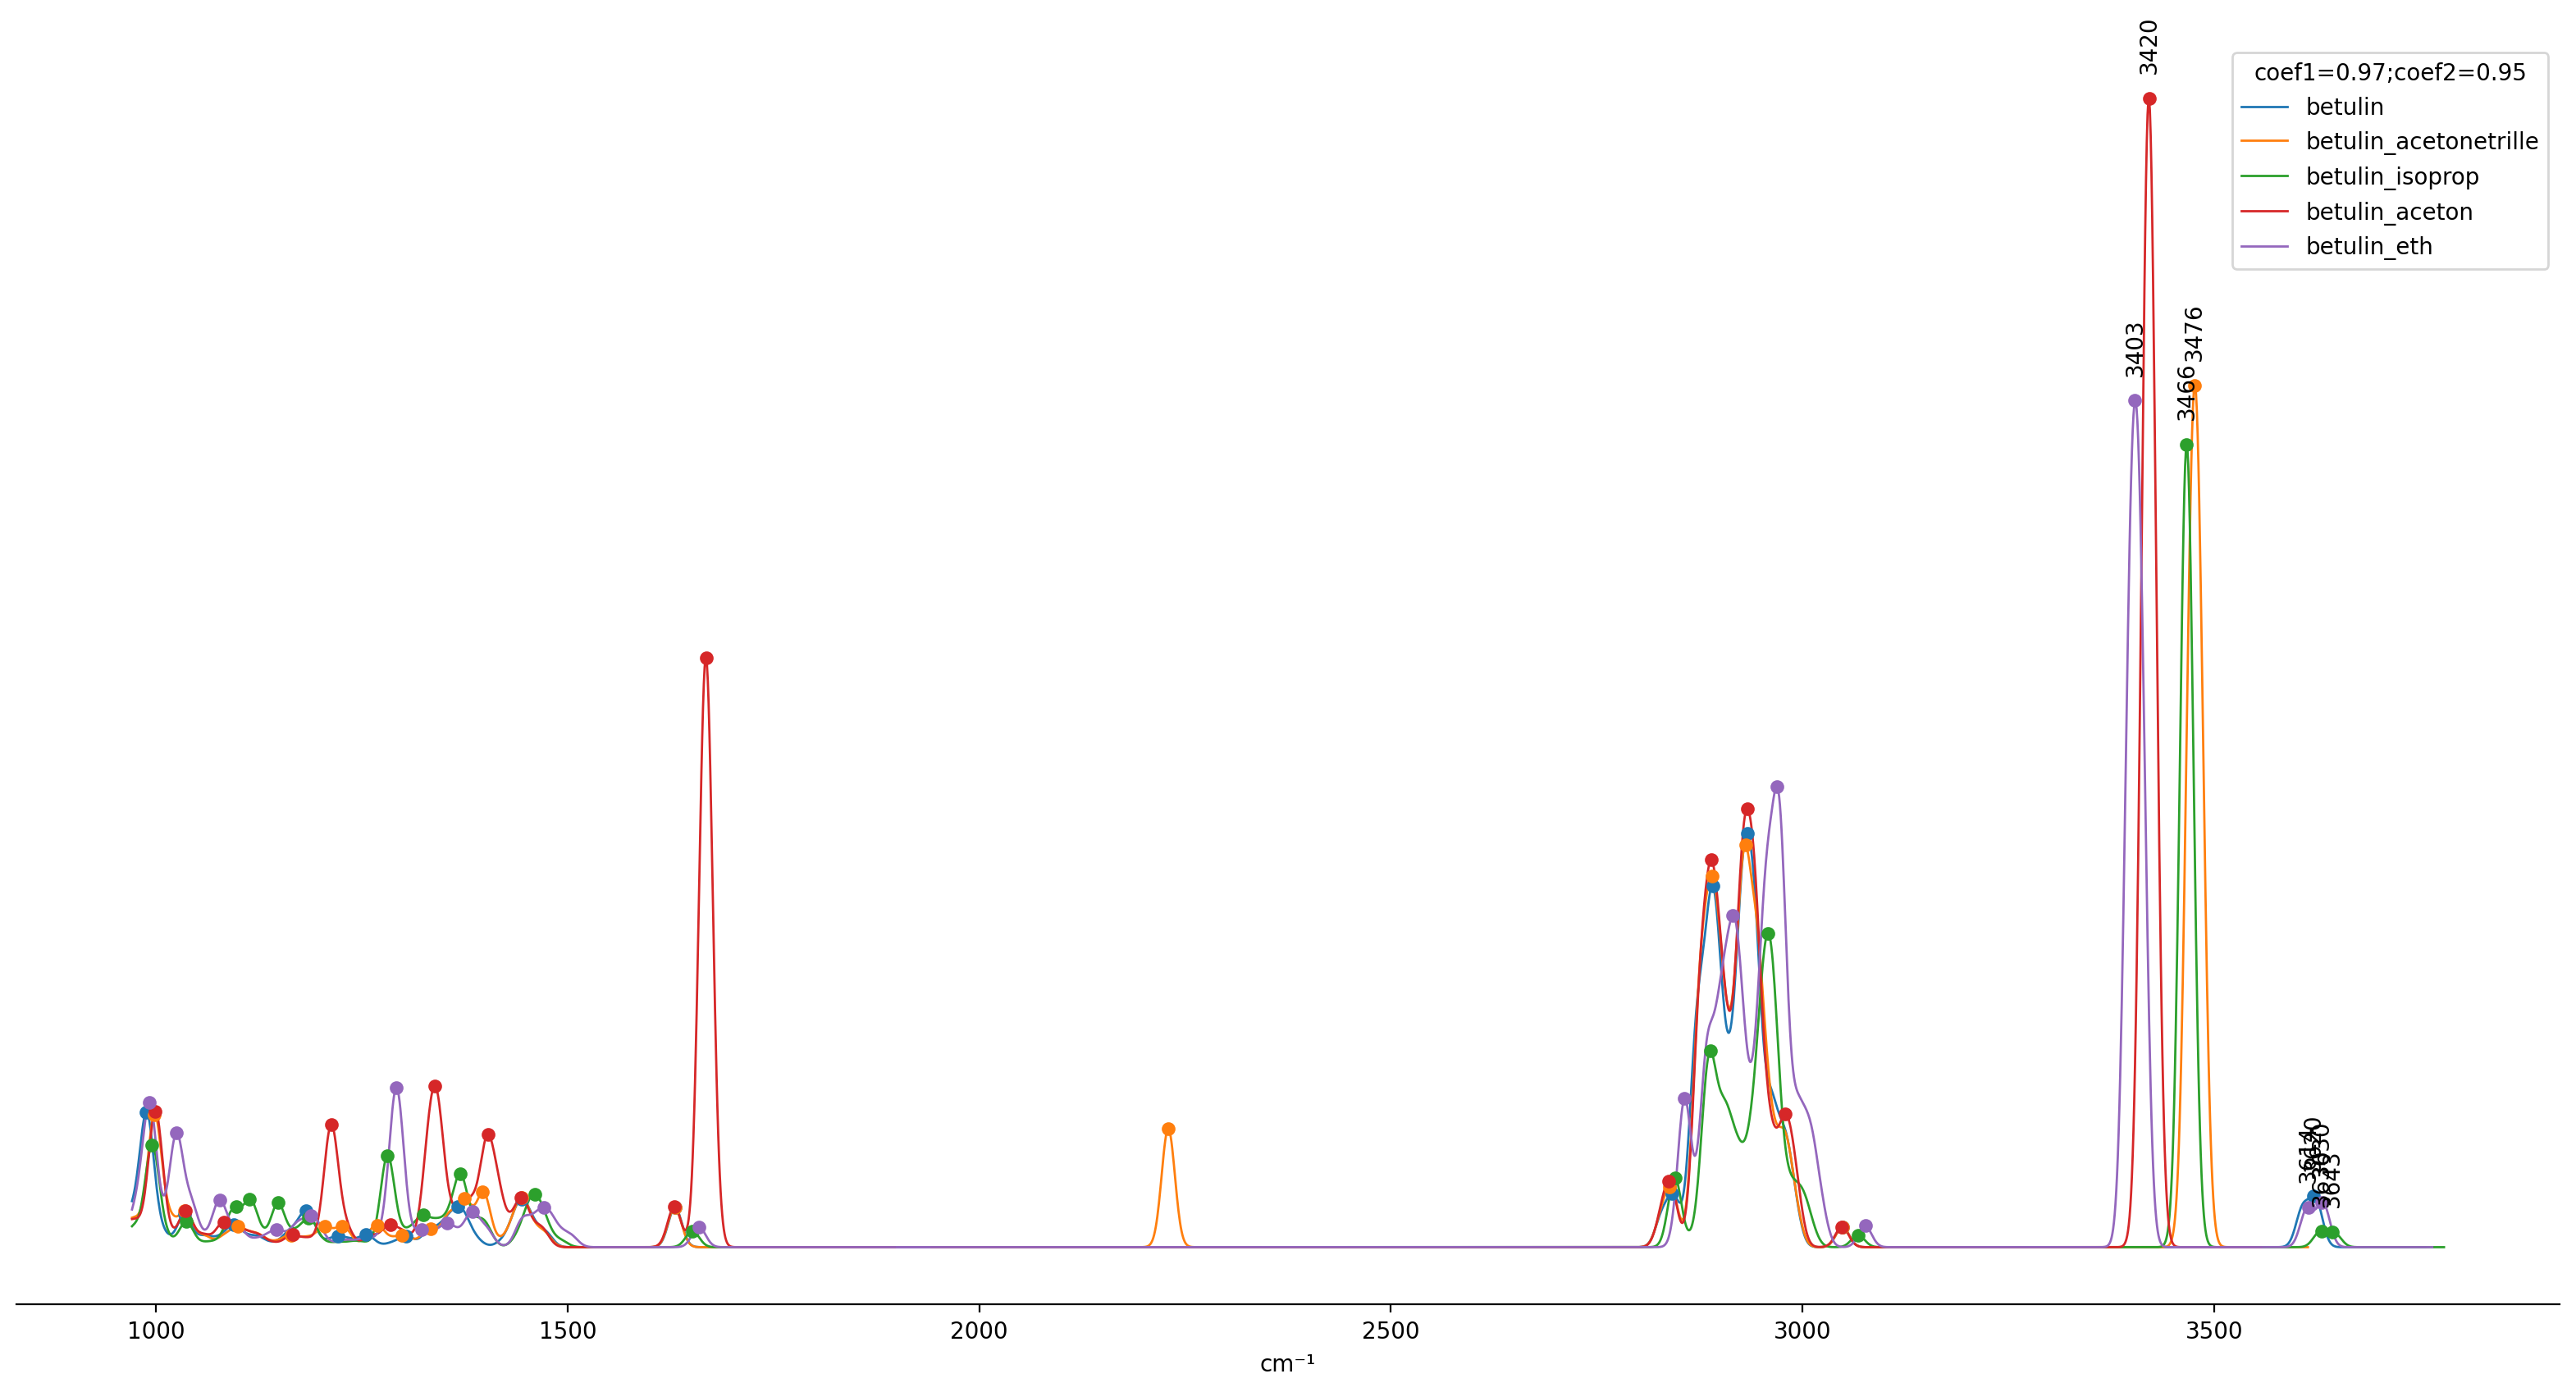

In [38]:

plot_all([betulin, betulin_acetonetrille, betulin_isoprop, betulin_aceton, betulin_eth,], 
          ['betulin', 'betulin_acetonetrille', 'betulin_isoprop', 'betulin_aceton', 'betulin_eth'],
          coef1=0.97, coef2=0.95, y_shift=0, showPeaksFrom=3100, forcedFirstPeaks=True, showLegend=True, showPeaks=True)

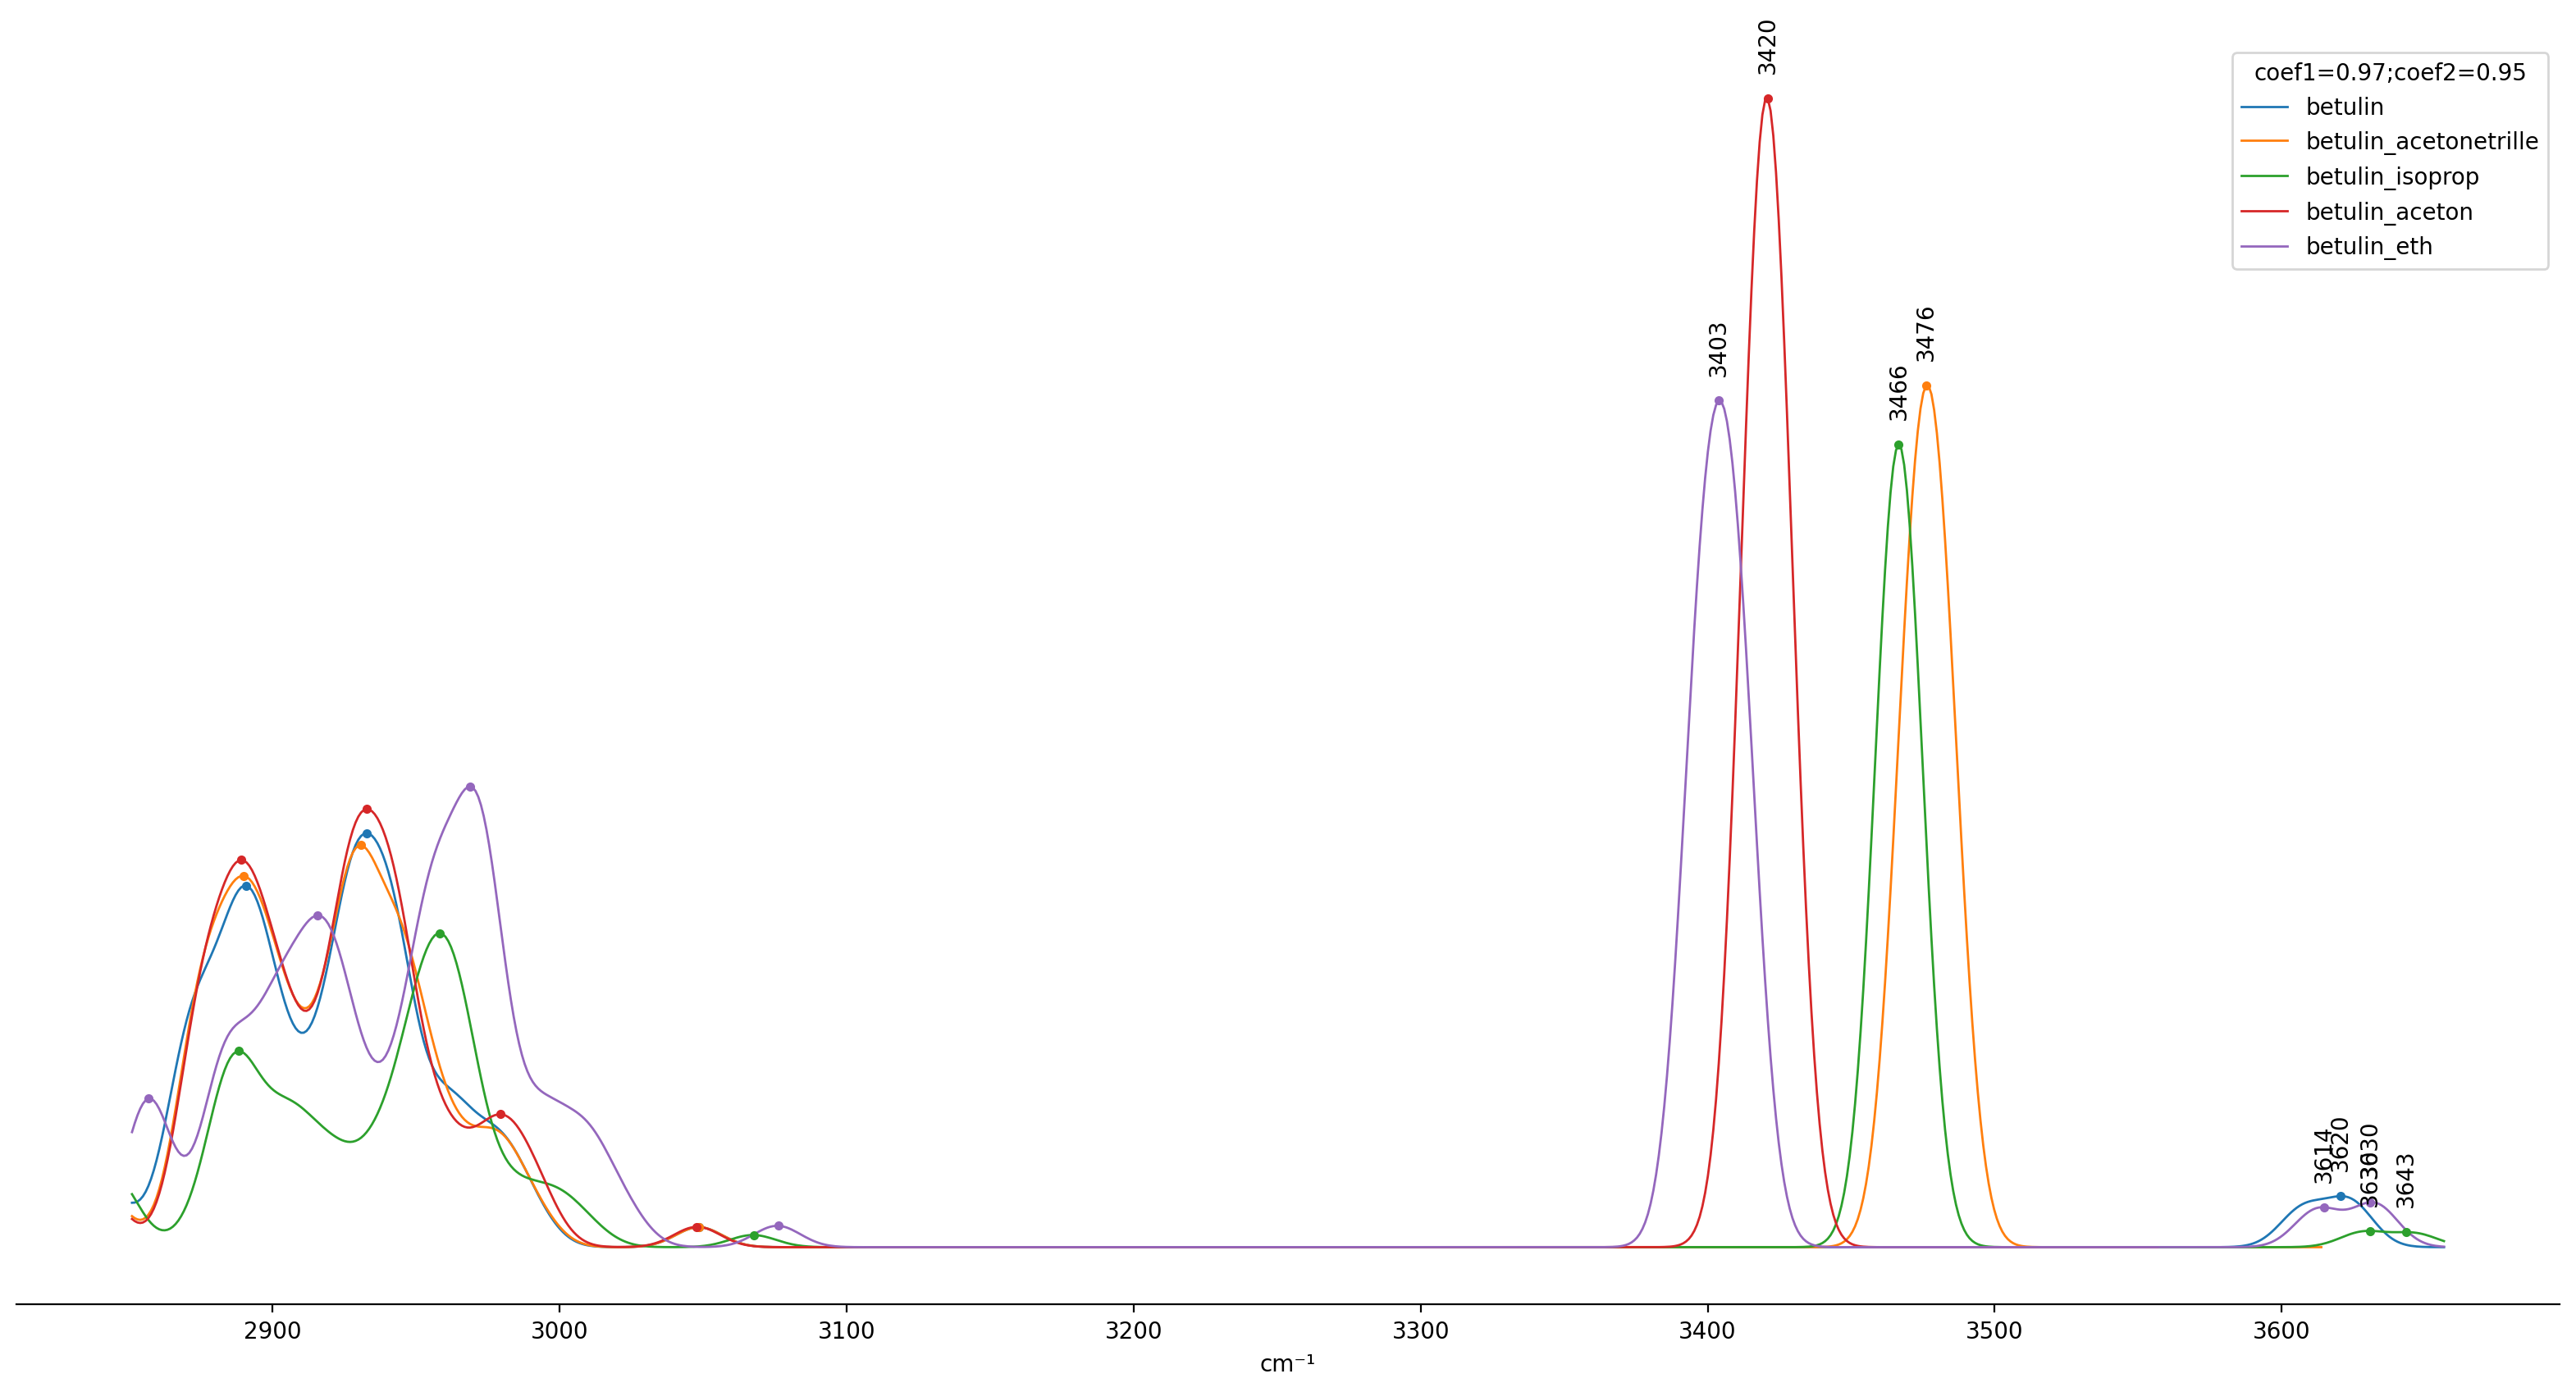

In [39]:
plot_all_ultra_short([betulin, betulin_acetonetrille, betulin_isoprop, betulin_aceton, betulin_eth,], 
          ['betulin', 'betulin_acetonetrille', 'betulin_isoprop', 'betulin_aceton', 'betulin_eth'],
           coef1=coef1, coef2=coef2, y_shift=0, showPeaks=True, forcedFirstPeaks=True, showXFrom=3000, showXUpto=3850)

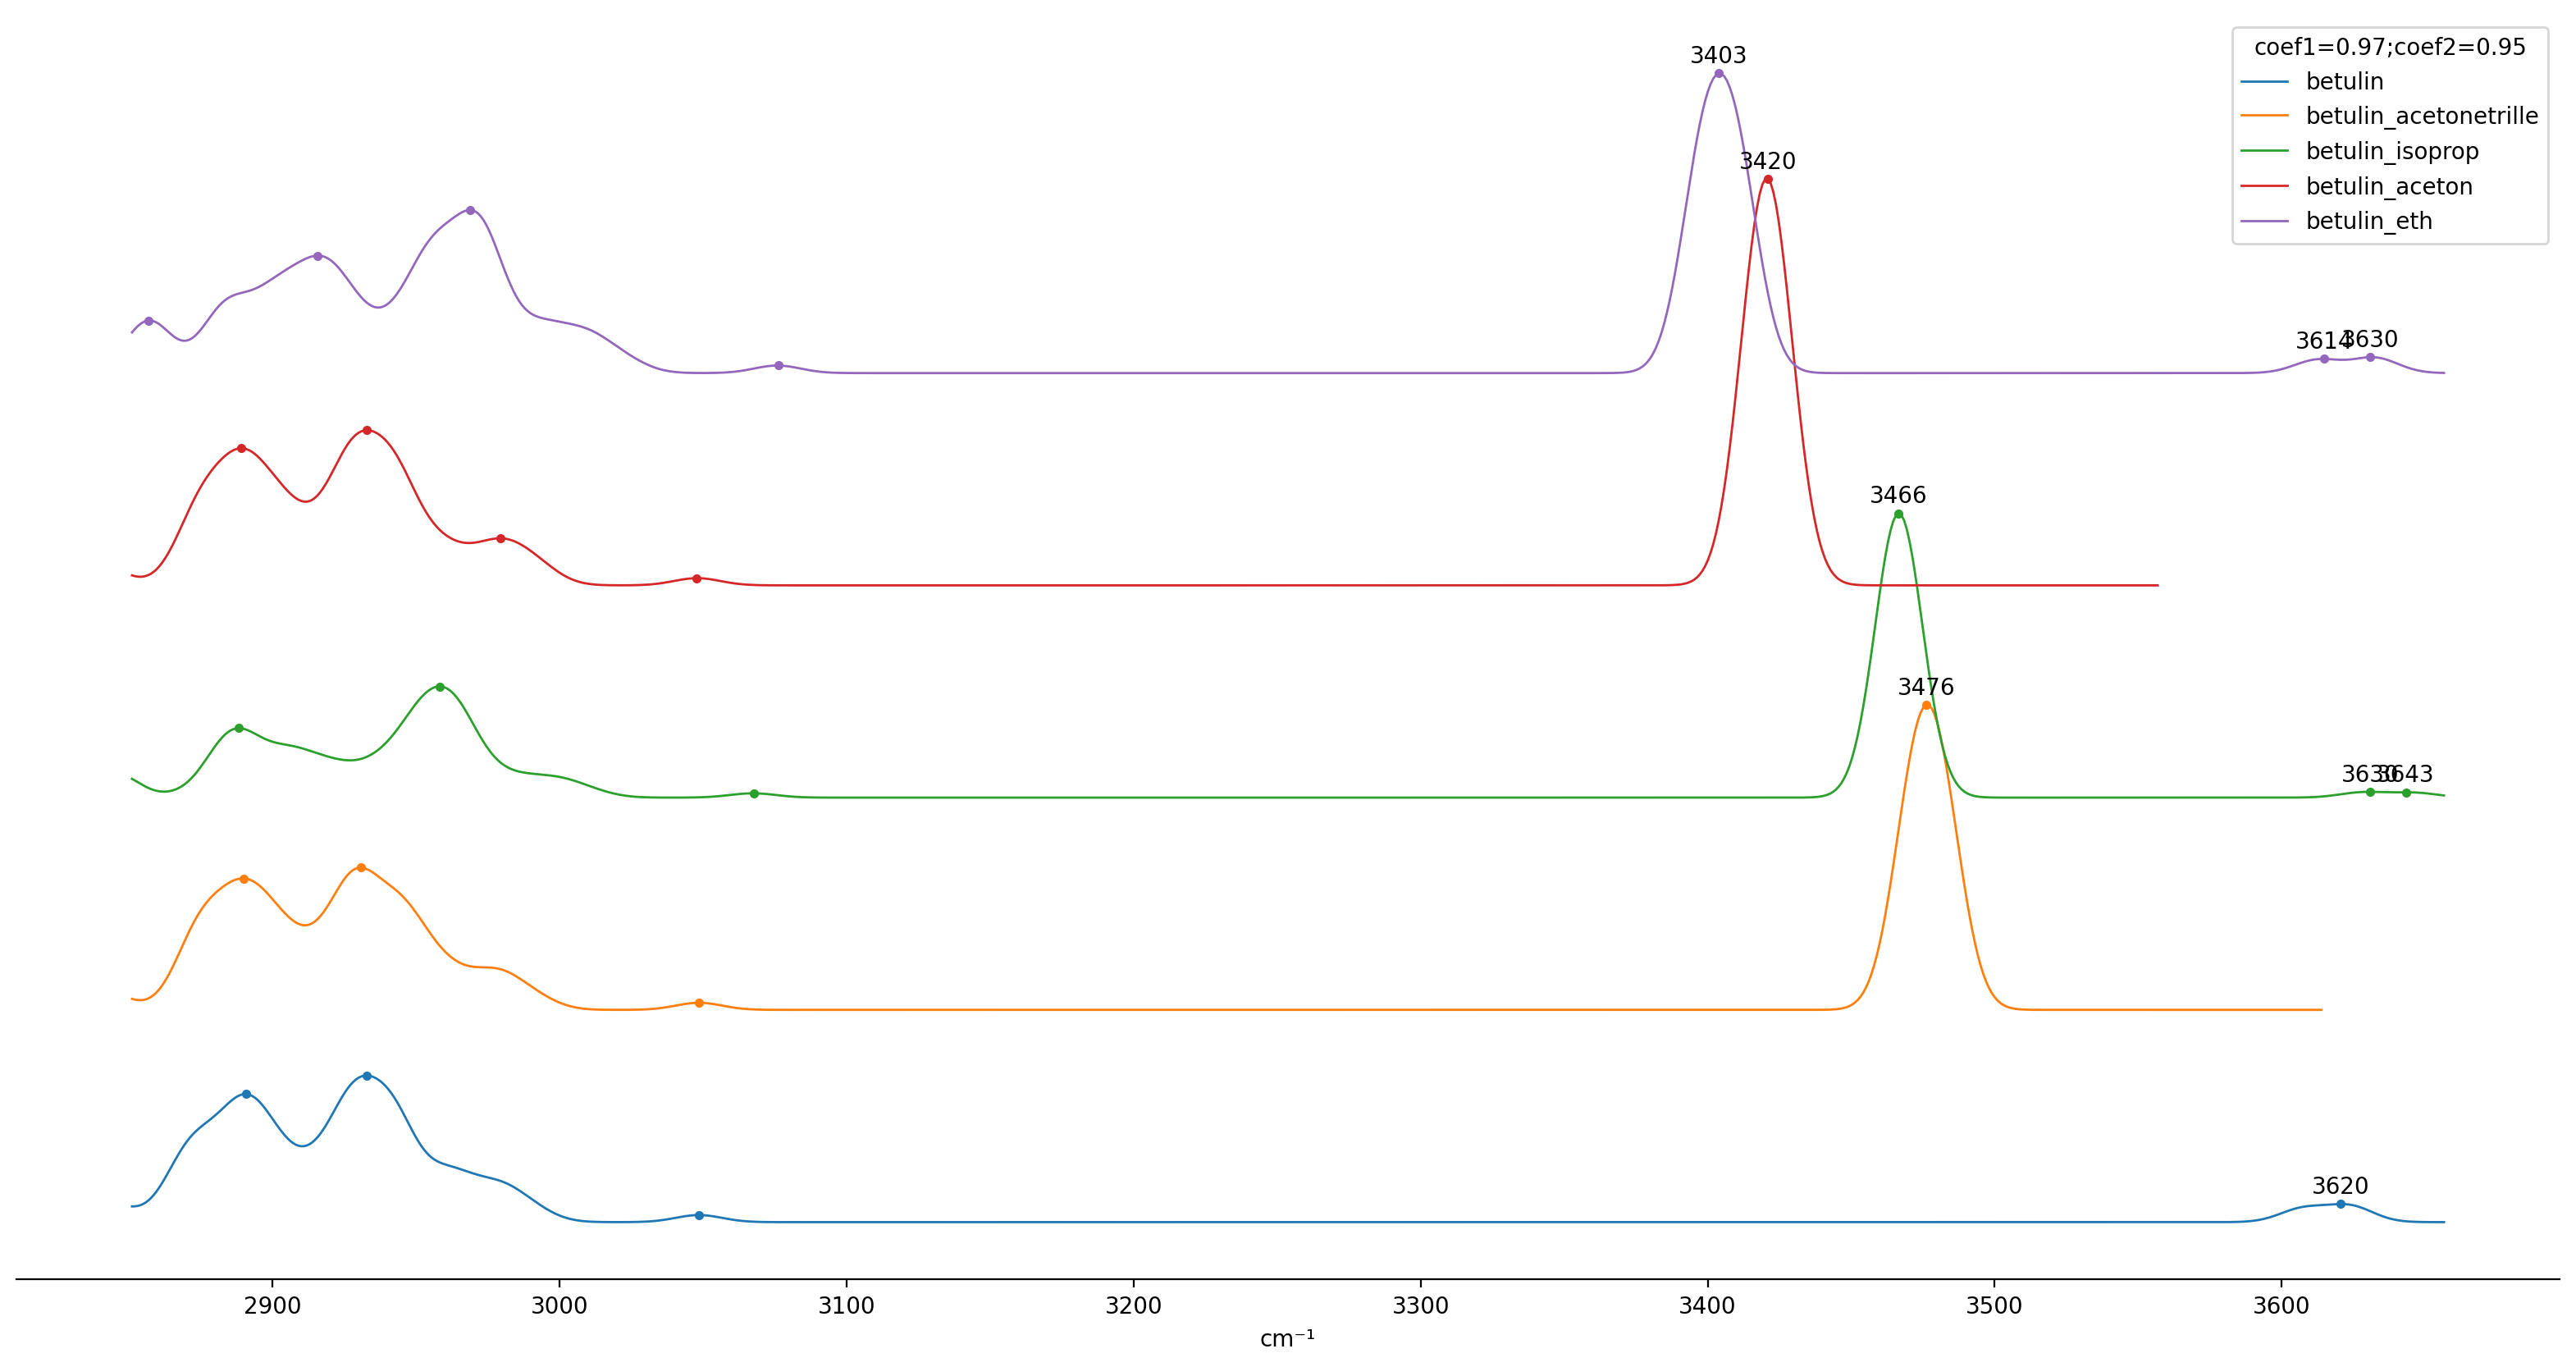

In [34]:
plot_all_ultra_short([betulin, betulin_acetonetrille, betulin_isoprop, betulin_aceton, betulin_eth,], 
          ['betulin', 'betulin_acetonetrille', 'betulin_isoprop', 'betulin_aceton', 'betulin_eth'],
           coef1=coef1, coef2=coef2, y_shift=1000, showPeaks=True, forcedFirstPeaks=True, showXFrom=3000, showXUpto=3850)